<a href="https://colab.research.google.com/github/debi201326/SAR-Image-Colorization/blob/main/SAR_to_RGB_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-ssim


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg19
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F
import pytorch_ssim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

In [ ]:
class SARColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.pairs = []
        self.transform = transform
        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            s1_dir = os.path.join(cls_path, 's1')
            s2_dir = os.path.join(cls_path, 's2')
            if not os.path.isdir(s1_dir) or not os.path.isdir(s2_dir):
                continue
            s1_imgs = sorted(os.listdir(s1_dir))
            s2_imgs = sorted(os.listdir(s2_dir))
            for s1_img, s2_img in zip(s1_imgs, s2_imgs):
                self.pairs.append((os.path.join(s1_dir, s1_img), os.path.join(s2_dir, s2_img)))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        s1_path, s2_path = self.pairs[idx]
        sar_img = Image.open(s1_path).convert('L')
        real_img = Image.open(s2_path).convert('RGB')
        if self.transform:
            sar_img = self.transform(sar_img)
            real_img = self.transform(real_img)
        return sar_img, real_img


In [ ]:
# ----------------- Generator ------------------
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [ ]:
# ----------------- Discriminator ------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, sar, color):
        x = torch.cat([sar, color], dim=1)
        return self.net(x)

In [ ]:
# ----------------- Training Setup ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SARColorizationDataset("/kaggle/input/sar-train-dataset/sar_images/v2", transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()
vgg = vgg19(pretrained=True).features[:16].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False
criterion_perceptual = nn.MSELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [ ]:
# ----------------- Track losses ------------------
loss_G_list, loss_D_list = [], []
loss_L1_list, loss_GAN_list, loss_perceptual_list = [], [], []

num_epochs = 100
for epoch in range(num_epochs):
    for i, (sar, real) in enumerate(train_loader):
        sar, real = sar.to(device), real.to(device)

        # Generator
        optimizer_G.zero_grad()
        gen_color = generator(sar)
        pred_fake = discriminator(sar, gen_color)
        valid = torch.ones_like(pred_fake)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_L1 = criterion_L1(gen_color, real)
        loss_perceptual = criterion_perceptual(vgg(gen_color), vgg(real))
        loss_G = loss_GAN + 100 * loss_L1 + 0.1 * loss_perceptual
        loss_G.backward()
        optimizer_G.step()

        # Discriminator
        optimizer_D.zero_grad()
        pred_real = discriminator(sar, real)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        pred_fake = discriminator(sar, gen_color.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Store losses
        loss_G_list.append(loss_G.item())
        loss_D_list.append(loss_D.item())
        loss_L1_list.append(loss_L1.item())
        loss_GAN_list.append(loss_GAN.item())
        loss_perceptual_list.append(loss_perceptual.item())

        if i % 50 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

print("Training complete!")

[Epoch 0/100] [Batch 0] Loss_D: 0.7080 Loss_G: 60.3474
[Epoch 0/100] [Batch 50] Loss_D: 0.1420 Loss_G: 21.5733
[Epoch 0/100] [Batch 100] Loss_D: 0.2070 Loss_G: 16.7039
[Epoch 0/100] [Batch 150] Loss_D: 0.4003 Loss_G: 18.1478
[Epoch 0/100] [Batch 200] Loss_D: 0.1658 Loss_G: 19.1630
[Epoch 1/100] [Batch 0] Loss_D: 0.2730 Loss_G: 15.9290
[Epoch 1/100] [Batch 50] Loss_D: 0.0539 Loss_G: 20.5190
[Epoch 1/100] [Batch 100] Loss_D: 0.5759 Loss_G: 20.3573
[Epoch 1/100] [Batch 150] Loss_D: 0.4078 Loss_G: 19.0642
[Epoch 1/100] [Batch 200] Loss_D: 0.5665 Loss_G: 17.7820
[Epoch 2/100] [Batch 0] Loss_D: 0.4199 Loss_G: 17.8622
[Epoch 2/100] [Batch 50] Loss_D: 0.2752 Loss_G: 20.4781
[Epoch 2/100] [Batch 100] Loss_D: 0.0772 Loss_G: 20.2627
[Epoch 2/100] [Batch 150] Loss_D: 0.1060 Loss_G: 19.5546
[Epoch 2/100] [Batch 200] Loss_D: 0.0783 Loss_G: 19.4683
[Epoch 3/100] [Batch 0] Loss_D: 0.0321 Loss_G: 20.7402
[Epoch 3/100] [Batch 50] Loss_D: 0.4315 Loss_G: 18.0387
[Epoch 3/100] [Batch 100] Loss_D: 0.2875 Lo

In [ ]:
torch.save(generator, "/kaggle/working/vgg_generator_full_model.pth")
torch.save(discriminator, "/kaggle/working/vgg_discriminator_full_model.pth")

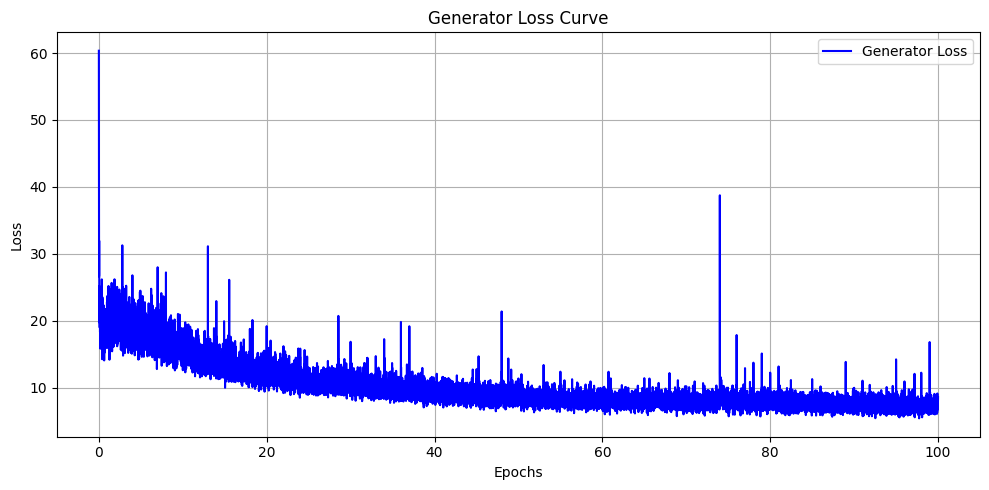

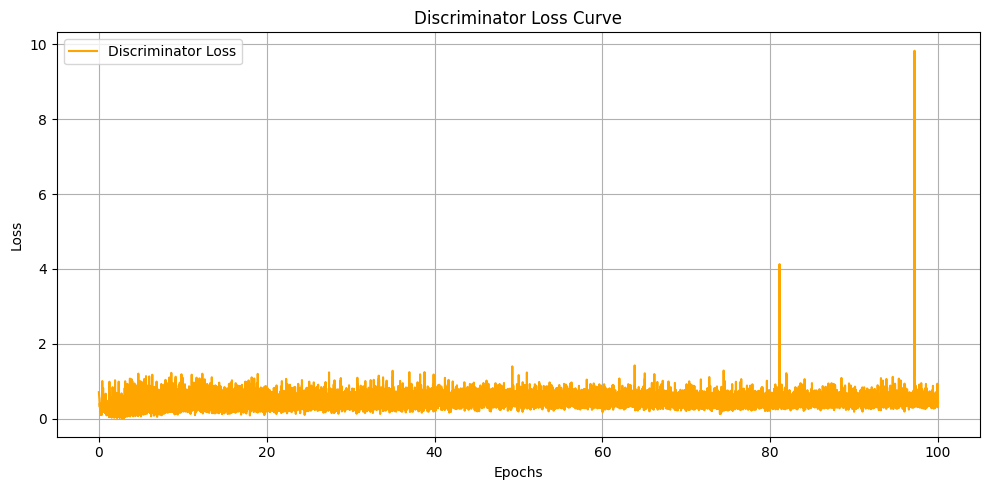

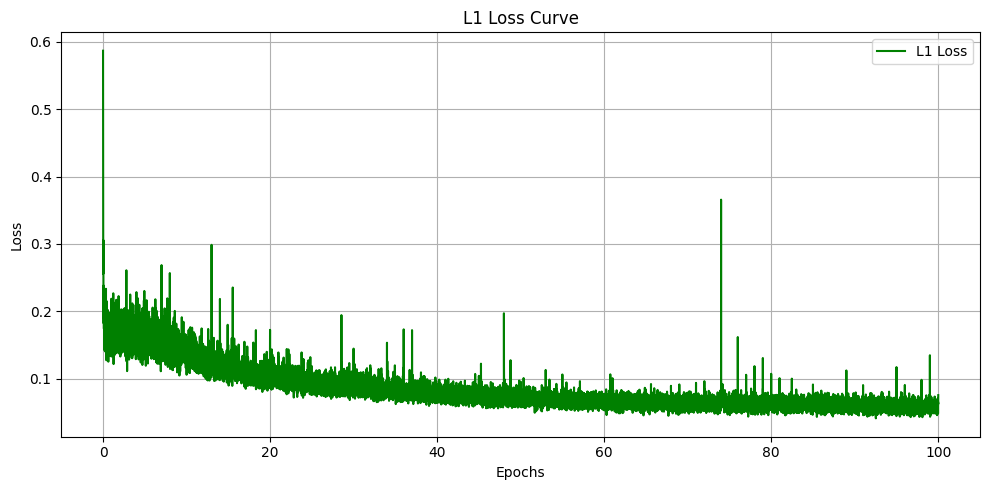

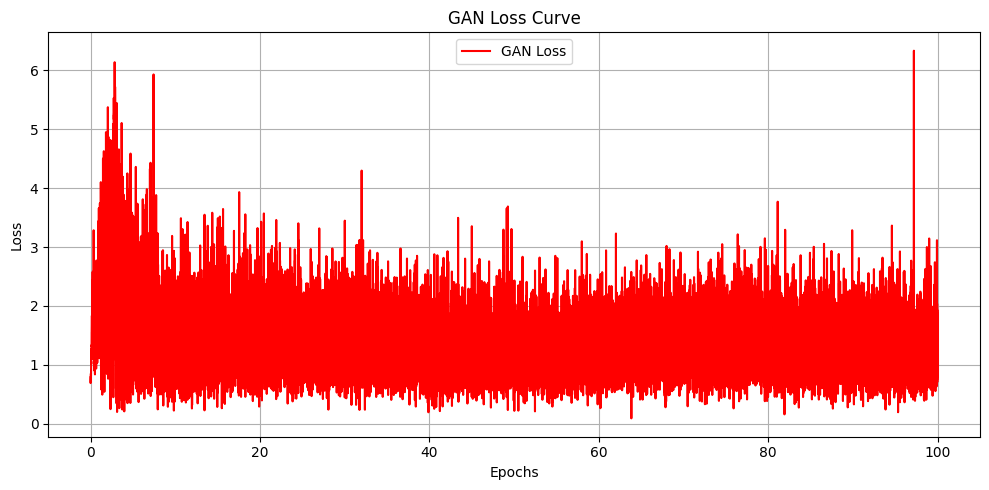

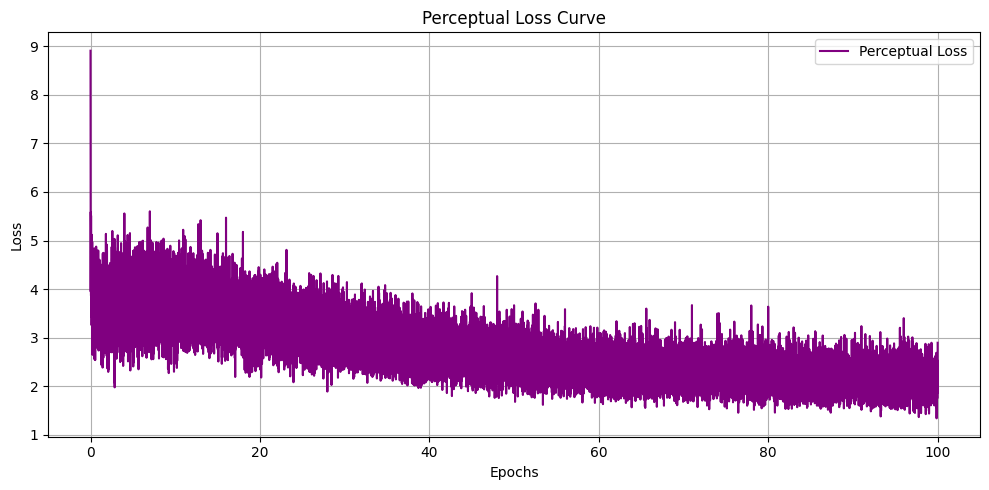

In [ ]:
import matplotlib.pyplot as plt
import os

# Create folder for saving loss plots
os.makedirs("loss_plots", exist_ok=True)

# Define loss names and their corresponding lists
loss_dict = {
    "Generator Loss": loss_G_list,
    "Discriminator Loss": loss_D_list,
    "L1 Loss": loss_L1_list,
    "GAN Loss": loss_GAN_list,
    "Perceptual Loss": loss_perceptual_list
}

# Consistent color scheme
color_scheme = {
    "Generator Loss": "blue",
    "Discriminator Loss": "orange",
    "L1 Loss": "green",
    "GAN Loss": "red",
    "Perceptual Loss": "purple"
}

# Calculate batches per epoch
batches_per_epoch = len(train_loader)

# Plot each loss separately
for loss_name, loss_values in loss_dict.items():
    steps = list(range(len(loss_values)))
    epochs = [step / batches_per_epoch for step in steps]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_values, label=loss_name, color=color_scheme[loss_name])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{loss_name} Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    filename = f"loss_plots/{loss_name.replace(' ', '_').lower()}_epochwise.png"
    plt.savefig(filename, dpi=300)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import os

# Create folder for saving loss plots
os.makedirs("loss_plots", exist_ok=True)

# Define loss names and their corresponding lists
loss_dict = {
    "Generator Loss": loss_G_list,
    "Discriminator Loss": loss_D_list,
    "L1 Loss": loss_L1_list,
    "GAN Loss": loss_GAN_list,
    "Perceptual Loss": loss_perceptual_list
}

# Calculate batches per epoch
batches_per_epoch = len(train_loader)

# Plot each loss with epochs on x-axis
for loss_name, loss_values in loss_dict.items():
    steps = list(range(len(loss_values)))
    epochs = [step / batches_per_epoch for step in steps]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_values, label=loss_name, color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{loss_name} Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    filename = f"loss_plots/{loss_name.replace(' ', '_').lower()}_epochwise.png"
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"✅ Saved: {filename}")


✅ Saved: loss_plots/generator_loss_epochwise.png
✅ Saved: loss_plots/discriminator_loss_epochwise.png
✅ Saved: loss_plots/l1_loss_epochwise.png
✅ Saved: loss_plots/gan_loss_epochwise.png
✅ Saved: loss_plots/perceptual_loss_epochwise.png


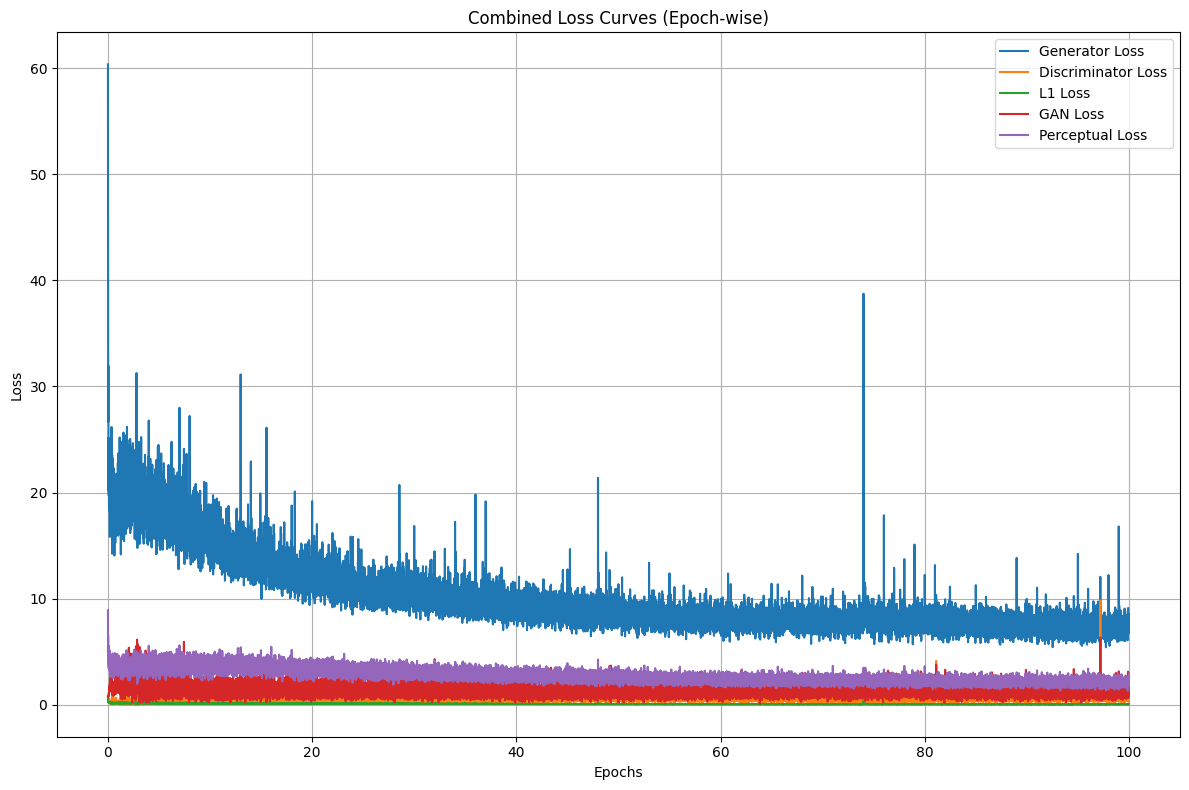

In [ ]:
# Plot all losses together with epoch-wise x-axis
plt.figure(figsize=(12, 8))

for loss_name, loss_values in loss_dict.items():
    steps = list(range(len(loss_values)))
    epochs = [step / batches_per_epoch for step in steps]
    plt.plot(epochs, loss_values, label=loss_name)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss Curves (Epoch-wise)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_plots/combined_loss_curves_epochwise.png", dpi=300)
plt.show()


In [ ]:
plt.figure(figsize=(12, 8))

for loss_name, loss_values in loss_dict.items():
    steps = list(range(len(loss_values)))
    epochs = [step / batches_per_epoch for step in steps]
    plt.plot(epochs, loss_values, label=loss_name, color=color_scheme[loss_name])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss Curves (Epoch-wise)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# ✅ Save as high-res PNG
plt.savefig("loss_plots/combined_loss_curves_epochwise.png", dpi=300)
print("✅ Saved: loss_plots/combined_loss_curves_epochwise.png")

# Do NOT show the plot
plt.close()


✅ Saved: loss_plots/combined_loss_curves_epochwise.png


In [ ]:
# ----------------- Evaluation PSNR & SSIM ------------------
def tensor_to_np(img_tensor):
    img_tensor = img_tensor.detach().cpu().clamp(-1, 1)
    img_tensor = (img_tensor + 1) / 2
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    return np.clip(img_np, 0, 1)

def evaluate_psnr_ssim(generator, dataloader):
    generator.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0
    with torch.no_grad():
        for sar_img, gt_img in tqdm(dataloader):
            sar_img = sar_img.to(device)
            gt_img = gt_img.to(device)
            output = generator(sar_img)
            pred_np = tensor_to_np(output)
            gt_np = tensor_to_np(gt_img)
            psnr = peak_signal_noise_ratio(gt_np, pred_np, data_range=1.0)
            ssim = structural_similarity(gt_np, pred_np, channel_axis=-1, data_range=1.0)
            total_psnr += psnr
            total_ssim += ssim
            count += 1

    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    print(f"\n✅ Average PSNR over {count} images: {avg_psnr:.4f} dB")
    print(f"✅ Average SSIM over {count} images: {avg_ssim:.4f}")



In [ ]:
# Load eval dataset and run evaluation
eval_dataset = SARColorizationDataset(
    root_dir="/kaggle/input/test-sar-dataset/sar test data/v2",
    transform=transform
)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

evaluate_psnr_ssim(generator, eval_loader)

100%|██████████| 40/40 [00:01<00:00, 25.79it/s]


✅ Average PSNR over 40 images: 28.0785 dB
✅ Average SSIM over 40 images: 0.7274


In [ ]:
def tensor_to_np_display(img_tensor):
    img_tensor = img_tensor.detach().cpu().clamp(-1, 1)
    img_tensor = (img_tensor + 1) / 2
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    return np.clip(img_np, 0, 1)

def show_per_class_grids(generator, dataset, device, root_dir, class_names):
    generator.eval()
    class_to_indices = {cls: [] for cls in class_names}

    for idx in range(len(dataset)):
        sar_path, _ = dataset.pairs[idx]
        sar_path = sar_path.replace("\\", "/")
        for cls in class_names:
            if f"/{cls}/" in sar_path:
                class_to_indices[cls].append(idx)
                break

    with torch.no_grad():
        for cls in class_names:
            indices = class_to_indices[cls][:8]
            if len(indices) < 8:
                continue

            fig, axes = plt.subplots(2, 8, figsize=(16, 5))

            for i, idx in enumerate(indices):
                sar_img, gt_img = dataset[idx]
                input_tensor = sar_img.unsqueeze(0).to(device)
                gt_tensor = gt_img.unsqueeze(0).to(device)
                output = generator(input_tensor)

                pred_np = tensor_to_np_display(output)
                gt_np = tensor_to_np_display(gt_tensor)

                axes[0][i].imshow(pred_np)
                axes[0][i].axis("off")

                axes[1][i].imshow(gt_np)
                axes[1][i].axis("off")

            plt.subplots_adjust(wspace=0.1, hspace=0.2)
            plt.tight_layout()
            plt.show()


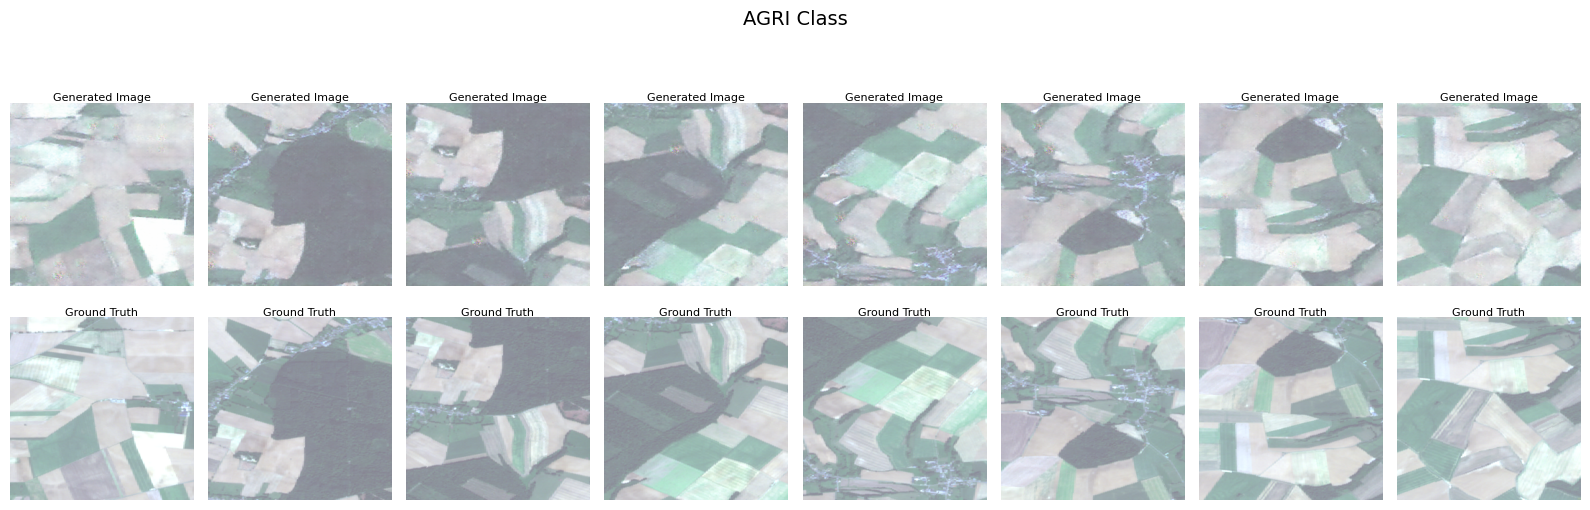

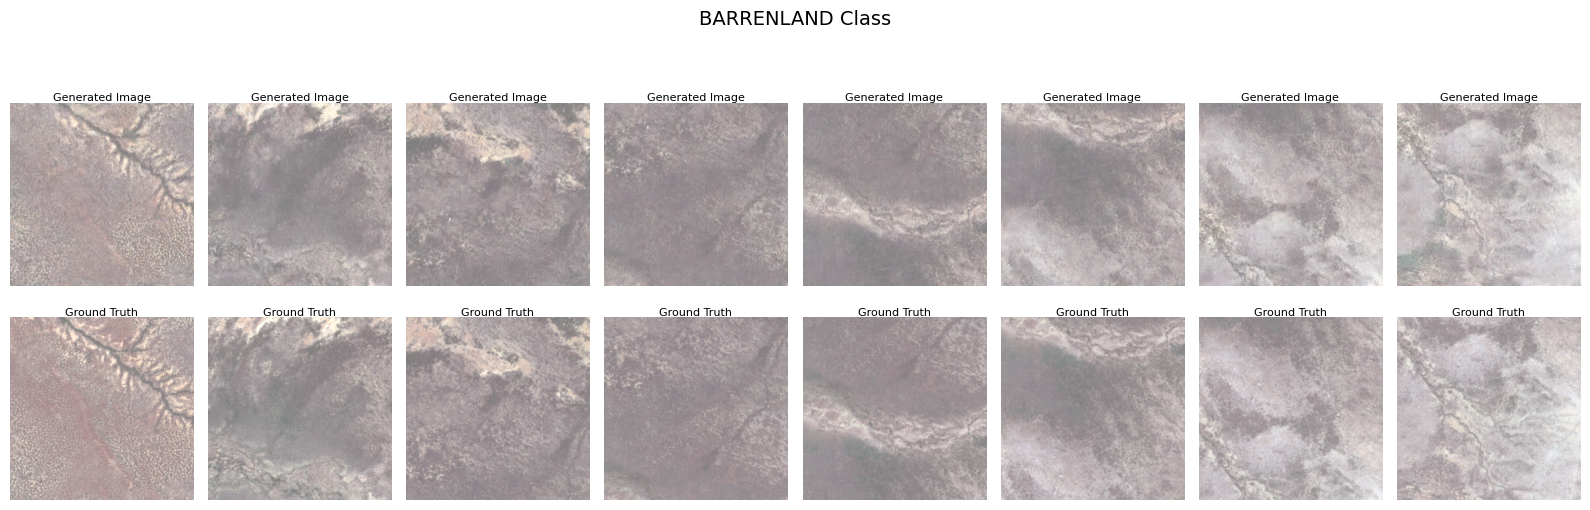

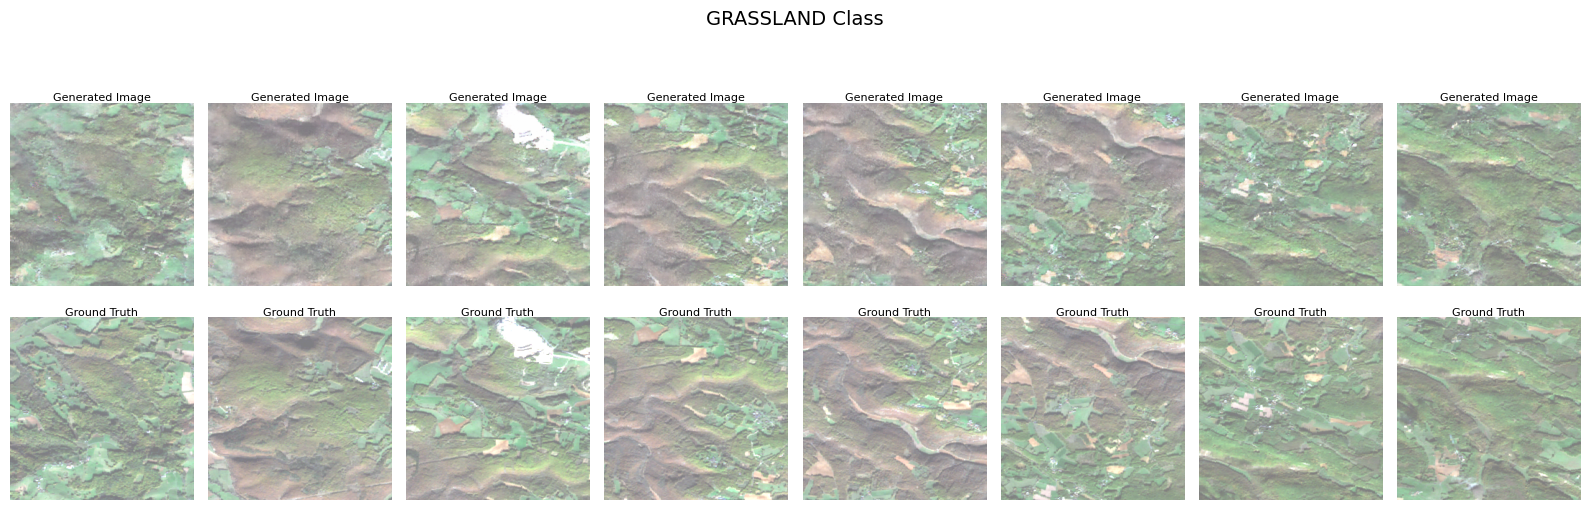

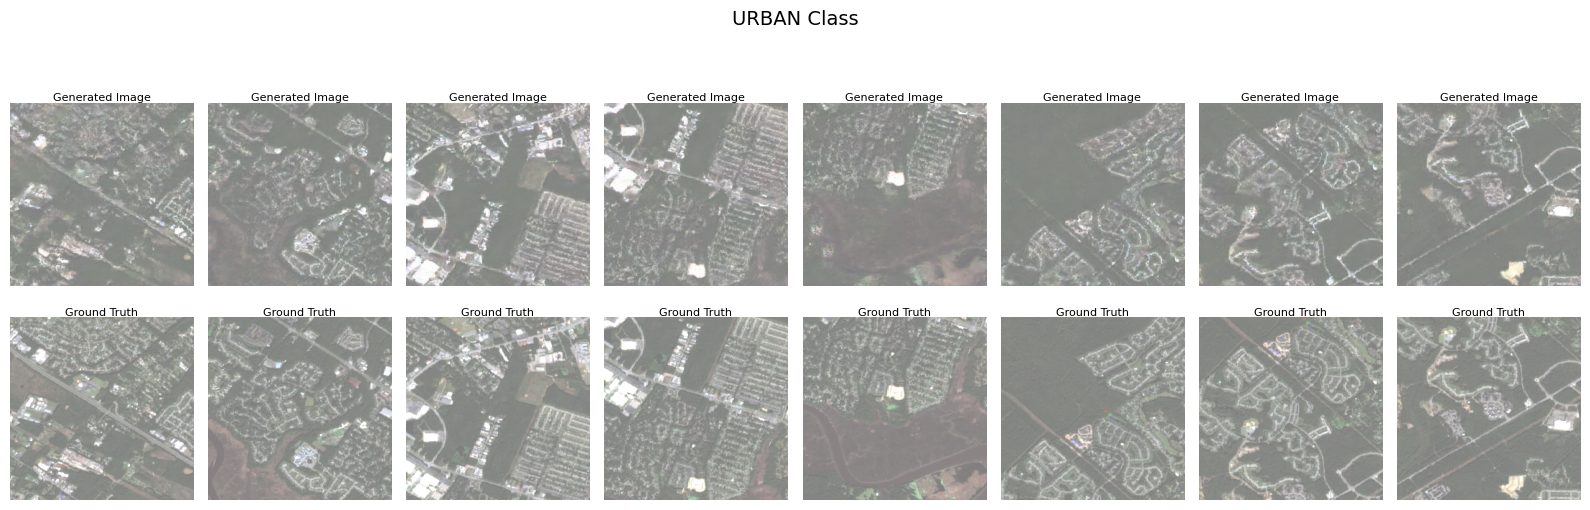

In [ ]:
class_names = ["agri", "barrenland", "grassland", "urban"]
show_per_class_grids(generator, train_dataset, device, root_dir="/kaggle/input/test-sar-dataset/sar test data/v2", class_names=class_names)


In [ ]:
def tensor_to_np_display(img_tensor):
    img_tensor = img_tensor.detach().cpu().clamp(-1, 1)
    img_tensor = (img_tensor + 1) / 2
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    return np.clip(img_np, 0, 1)

def plot_sample_grid(generator, dataset, indices, device, save_path=None, show=False):
    fig, axes = plt.subplots(2, len(indices), figsize=(len(indices)*2.5, 5))

    for i, idx in enumerate(indices):
        sar_img, gt_img = dataset[idx]
        input_tensor = sar_img.unsqueeze(0).to(device)
        gt_tensor = gt_img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = generator(input_tensor)

        pred_np = tensor_to_np_display(output)
        gt_np = tensor_to_np_display(gt_tensor)

        axes[0][i].imshow(pred_np)
        axes[0][i].axis("off")

        axes[1][i].imshow(gt_np)
        axes[1][i].axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

def show_and_save_class_grids(generator, dataset, device, root_dir, class_names, save_dir="/kaggle/working/class_grids_new", show=False):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)
    class_to_indices = {cls: [] for cls in class_names}

    for idx in range(len(dataset)):
        sar_path, _ = dataset.pairs[idx]
        sar_path = sar_path.replace("\\", "/")
        for cls in class_names:
            if f"/{cls}/" in sar_path:
                class_to_indices[cls].append(idx)
                break

    for cls in class_names:
        indices = class_to_indices[cls][:8]
        if len(indices) < 8:
            continue
        save_path = os.path.join(save_dir, f"{cls}_comparison.png")
        plot_sample_grid(generator, dataset, indices, device, save_path=save_path, show=show)


In [ ]:
class_names = ["agri", "barrenland", "grassland", "urban"]
show_and_save_class_grids(generator, train_dataset, device, root_dir="/kaggle/input/sar-dataset/sar_images/v2", class_names=class_names, show=False)


✅ Saved: /kaggle/working/class_grids_new/agri_comparison.png
✅ Saved: /kaggle/working/class_grids_new/barrenland_comparison.png
✅ Saved: /kaggle/working/class_grids_new/grassland_comparison.png
✅ Saved: /kaggle/working/class_grids_new/urban_comparison.png
